In [39]:
# Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import TimeSeriesSplit
from scipy.stats import zscore
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objects as go
import statsmodels.api as sm

In [40]:
# Read the dataset
# Transform the excel file in csv file
df = pd.read_excel('energy_demand.xlsx')


csv_file_path = 'energy_demand.csv'

df.to_csv(csv_file_path, index = False)

print(df)

            Date  Hour    load          T
0     2012-01-01     0  2872.0  30.666667
1     2012-01-01     1  2698.0  32.000000
2     2012-01-01     2  2558.0  32.666667
3     2012-01-01     3  2444.0  30.000000
4     2012-01-01     4  2402.0  31.000000
...          ...   ...     ...        ...
26300 2014-12-31    20  4012.0  18.000000
26301 2014-12-31    21  3856.0  16.666667
26302 2014-12-31    22  3671.0  17.000000
26303 2014-12-31    23  3499.0  15.333333
26304 2014-12-31    24  3345.0  15.333333

[26305 rows x 4 columns]


In [41]:
# Data Understanding

# Display columns names
print(df.columns)

# Change the column names
new_column_names = {
    'load' : 'Load Value',
    'T' : 'Temperature'
}

df.rename(columns = new_column_names, inplace = True)

print("Update columns : ")
print(df.columns)

Index(['Date', 'Hour', 'load', 'T'], dtype='object')
Update columns : 
Index(['Date', 'Hour', 'Load Value', 'Temperature'], dtype='object')


In [42]:
# Display basic information for dataset
print(df.info())

# Check data types
print(df.dtypes)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26305 entries, 0 to 26304
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   Date         26305 non-null  datetime64[ns]
 1   Hour         26305 non-null  int64         
 2   Load Value   26305 non-null  float64       
 3   Temperature  26305 non-null  float64       
dtypes: datetime64[ns](1), float64(2), int64(1)
memory usage: 822.2 KB
None
Date           datetime64[ns]
Hour                    int64
Load Value            float64
Temperature           float64
dtype: object


In [43]:
# Display first few rows
print(df.head())

# Display last few rows
print(df.tail())

        Date  Hour  Load Value  Temperature
0 2012-01-01     0      2872.0    30.666667
1 2012-01-01     1      2698.0    32.000000
2 2012-01-01     2      2558.0    32.666667
3 2012-01-01     3      2444.0    30.000000
4 2012-01-01     4      2402.0    31.000000
            Date  Hour  Load Value  Temperature
26300 2014-12-31    20      4012.0    18.000000
26301 2014-12-31    21      3856.0    16.666667
26302 2014-12-31    22      3671.0    17.000000
26303 2014-12-31    23      3499.0    15.333333
26304 2014-12-31    24      3345.0    15.333333


In [44]:
# Display descriptive statistics
print(df.describe())

# Check for missing values
print(df.isnull().sum())
# Doesn't have missing values in the dataset

                                Date          Hour    Load Value   Temperature
count                          26305  26305.000000  26305.000000  26305.000000
mean   2013-07-01 11:30:01.710701312     12.499525   3303.752785     47.764988
min              2012-01-01 00:00:00      0.000000   1979.000000    -13.666667
25%              2012-09-30 00:00:00      6.000000   2867.000000     32.666667
50%              2013-07-01 00:00:00     12.000000   3364.000000     48.333333
75%              2014-04-01 00:00:00     18.000000   3690.000000     63.666667
max              2014-12-31 00:00:00     24.000000   5224.000000     95.000000
std                              NaN      6.922616    564.574798     19.338062
Date           0
Hour           0
Load Value     0
Temperature    0
dtype: int64


In [45]:
# Display unique values
for column in df.columns:
    # Print the column name and its unique values
    print(f"Unique values in {column}: {df[column].unique()}")

Unique values in Date: <DatetimeArray>
['2012-01-01 00:00:00', '2012-01-02 00:00:00', '2012-01-03 00:00:00',
 '2012-01-04 00:00:00', '2012-01-05 00:00:00', '2012-01-06 00:00:00',
 '2012-01-07 00:00:00', '2012-01-08 00:00:00', '2012-01-09 00:00:00',
 '2012-01-10 00:00:00',
 ...
 '2014-12-22 00:00:00', '2014-12-23 00:00:00', '2014-12-24 00:00:00',
 '2014-12-25 00:00:00', '2014-12-26 00:00:00', '2014-12-27 00:00:00',
 '2014-12-28 00:00:00', '2014-12-29 00:00:00', '2014-12-30 00:00:00',
 '2014-12-31 00:00:00']
Length: 1096, dtype: datetime64[ns]
Unique values in Hour: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24]
Unique values in Load Value: [2872. 2698. 2558. ... 4449. 4360. 4319.]
Unique values in Temperature: [ 30.666667    32.          32.66666667  30.          31.
  31.33333333  29.          33.33333333  36.66666667  40.33333333
  43.66666667  43.33333333  45.          44.66666667  41.66666667
  41.33333333  42.66666667  44.33333333  44.          43.
  

In [46]:
# Check for duplicated values
print(df.duplicated().sum())
# Don't have duplicated values

0


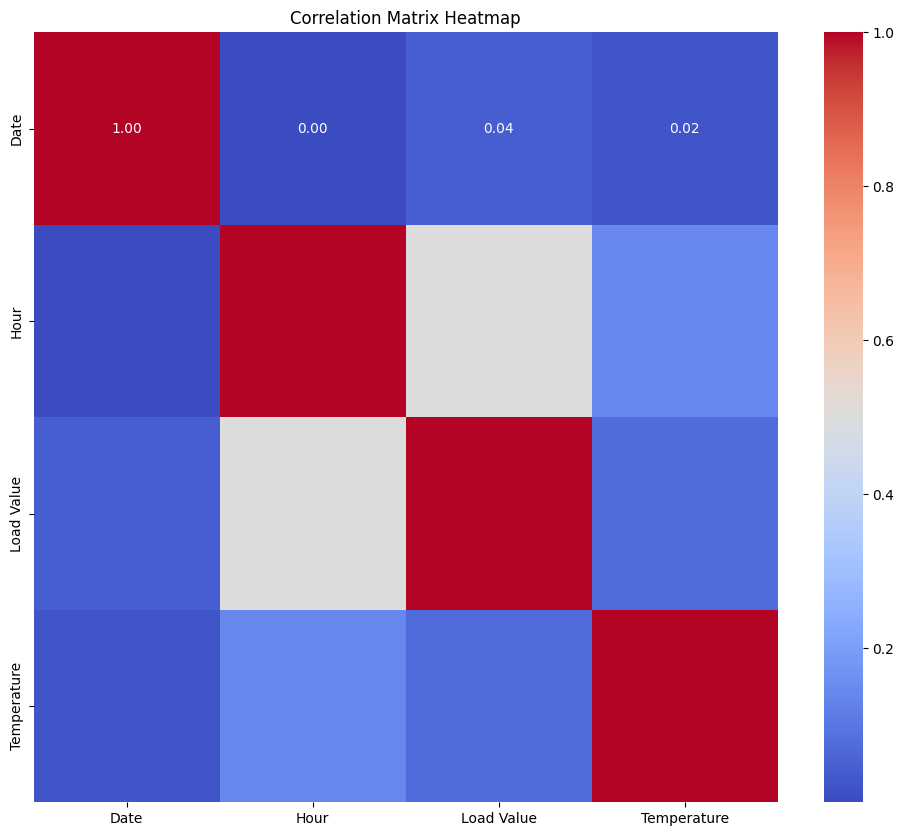

In [47]:
# Display correlation matrix
correlation_matrix = df.corr()

plt.figure(figsize = (12,10))

sns.heatmap(correlation_matrix, annot = True, cmap = 'coolwarm', fmt = ".2f")

plt.title('Correlation Matrix Heatmap')
plt.show()
# We can see we have an medium correlation beetween hour and Loan Value

c:\Users\diogo\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning:

is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead

c:\Users\diogo\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning:

is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead

c:\Users\diogo\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning:

is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead



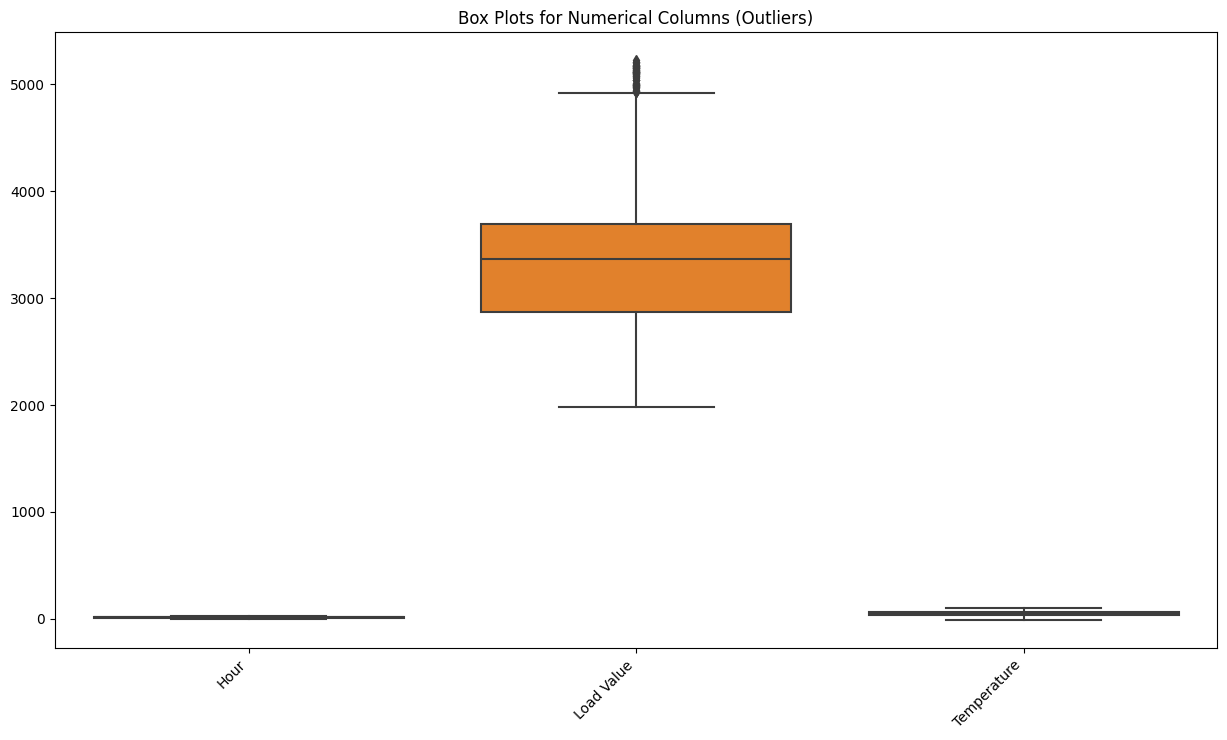

In [48]:
# Check for outliers in the dataset
numerical_columns = df.select_dtypes(include='number').columns

# Plot box plots for all numerical columns
plt.figure(figsize=(15, 8))
sns.boxplot(data=df[numerical_columns])
plt.title('Box Plots for Numerical Columns (Outliers)')
plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for better visibility
plt.show()
# Only have outliers in the Load Value column

In [49]:
# Check for anomalies
z_scores = zscore(df['Load Value'])
anomalies = (z_scores > 3) | (z_scores < -3)

# Display rows with anomalies
anomalies_df = df[anomalies]
print("Anomalies:")
print(anomalies_df)
print(anomalies_df.nunique())

Anomalies:
            Date  Hour  Load Value  Temperature
13476 2013-07-15    12      5007.0    86.000000
13477 2013-07-15    13      5040.0    88.000000
13478 2013-07-15    14      5088.0    89.333333
13479 2013-07-15    15      5112.0    90.333333
13480 2013-07-15    16      5132.0    91.000000
13481 2013-07-15    17      5151.0    91.666667
13482 2013-07-15    18      5152.0    91.333333
13483 2013-07-15    19      5113.0    89.666667
13500 2013-07-16    12      5053.0    86.666667
13501 2013-07-16    13      5103.0    88.333333
13502 2013-07-16    14      5147.0    88.666667
13503 2013-07-16    15      5124.0    87.666667
13504 2013-07-16    16      5104.0    88.000000
13505 2013-07-16    17      5110.0    90.000000
13506 2013-07-16    18      5098.0    89.666667
13507 2013-07-16    19      5042.0    87.000000
13525 2013-07-17    13      5076.0    86.333333
13526 2013-07-17    14      5133.0    88.666667
13527 2013-07-17    15      5166.0    89.000000
13528 2013-07-17    16      5

In [50]:
# Convert the 'Date' column to datetime format
df['Date'] = pd.to_datetime(df['Date'])
df['Hour'] = pd.to_timedelta(df['Hour'], unit='h')

# Create a new column 'DateTime' by combining 'Date' and 'Hour'
df['DateTime'] = df['Date'] + df['Hour']

# Drop the original 'Date' and 'Hour' columns if needed
df.drop(['Date', 'Hour'], axis=1, inplace=True)

print(df)

# Set DateTime as index of DataFrame
df.set_index('DateTime', inplace=True)

print(df)



       Load Value  Temperature            DateTime
0          2872.0    30.666667 2012-01-01 00:00:00
1          2698.0    32.000000 2012-01-01 01:00:00
2          2558.0    32.666667 2012-01-01 02:00:00
3          2444.0    30.000000 2012-01-01 03:00:00
4          2402.0    31.000000 2012-01-01 04:00:00
...           ...          ...                 ...
26300      4012.0    18.000000 2014-12-31 20:00:00
26301      3856.0    16.666667 2014-12-31 21:00:00
26302      3671.0    17.000000 2014-12-31 22:00:00
26303      3499.0    15.333333 2014-12-31 23:00:00
26304      3345.0    15.333333 2015-01-01 00:00:00

[26305 rows x 3 columns]
                     Load Value  Temperature
DateTime                                    
2012-01-01 00:00:00      2872.0    30.666667
2012-01-01 01:00:00      2698.0    32.000000
2012-01-01 02:00:00      2558.0    32.666667
2012-01-01 03:00:00      2444.0    30.000000
2012-01-01 04:00:00      2402.0    31.000000
...                         ...          ...
20

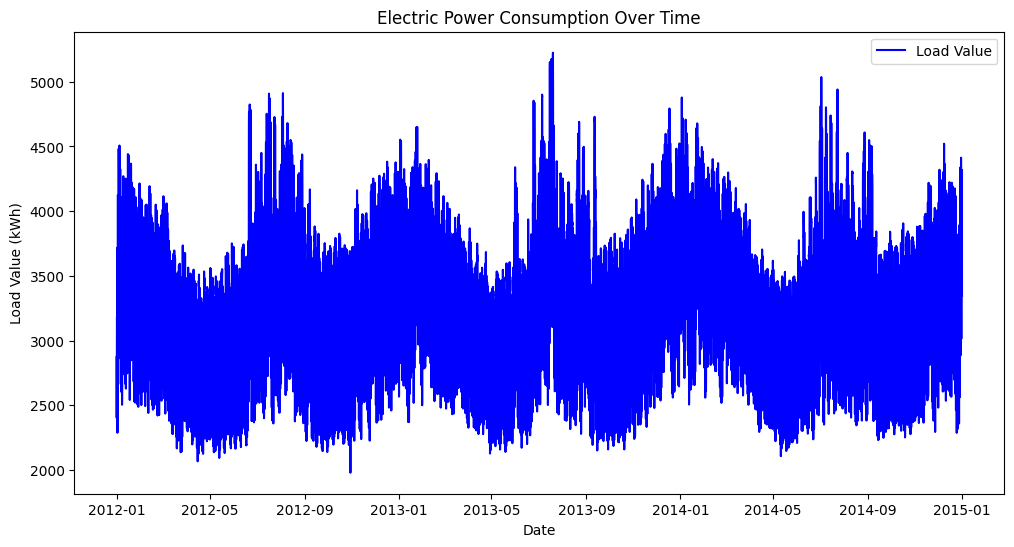

In [51]:
# Plot the time series of Load values
plt.figure(figsize=(12, 6))
plt.plot(df['Load Value'], label='Load Value', color='blue')
plt.title('Electric Power Consumption Over Time')
plt.xlabel('Date')
plt.ylabel('Load Value (kWh)')
plt.legend()
plt.show()

c:\Users\diogo\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning:

is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead

c:\Users\diogo\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning:

use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.



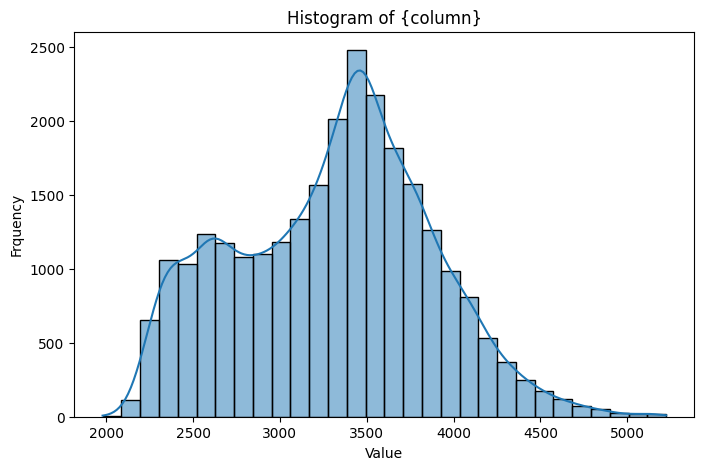

c:\Users\diogo\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning:

is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead

c:\Users\diogo\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning:

use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.



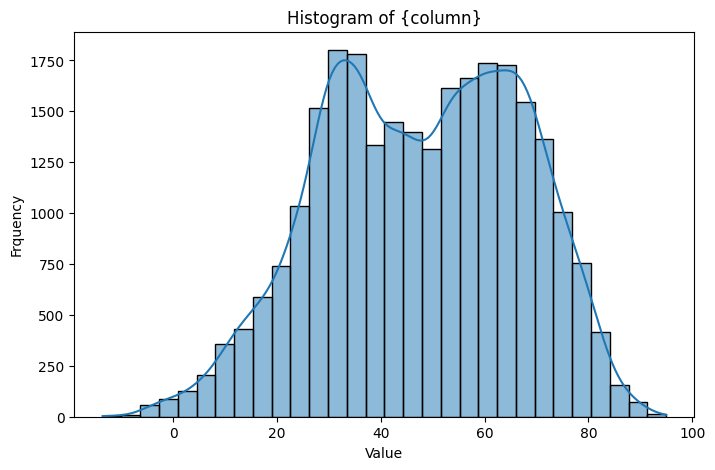

In [52]:
# Univariate Visualization
for column in df.columns:
    plt.figure(figsize=(8,5))
    sns.histplot(df[column], bins=30, kde=True)
    plt.title('Histogram of {column}')
    plt.xlabel('Value')
    plt.ylabel('Frquency')
    plt.show()

c:\Users\diogo\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning:

is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead

c:\Users\diogo\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning:

is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead



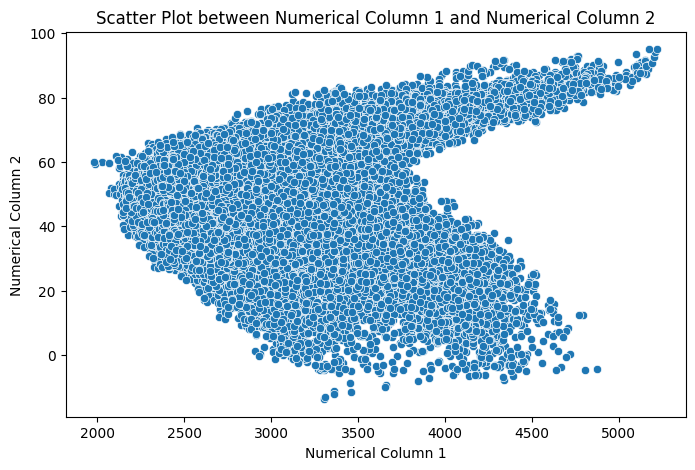

In [53]:
# Scatter plot for two numerical columns
plt.figure(figsize=(8, 5))
sns.scatterplot(x=df['Load Value'], y=df['Temperature'])
plt.title('Scatter Plot between Numerical Column 1 and Numerical Column 2')
plt.xlabel('Numerical Column 1')
plt.ylabel('Numerical Column 2')
plt.show()

In [54]:
# Split data into train-val-test
# Calculate the split points
total_samples = len(df)
train_split = int(0.8 * total_samples)
val_split = int(0.9 * total_samples)

# Split the data
train_set = df.iloc[:train_split]
val_set = df.iloc[train_split:val_split]
test_set = df.iloc[val_split:]

print(f"Train dates      : {train_set.index.min()} --- {train_set.index.max()}  (n={len(train_set)})")
print(f"Validation dates : {val_set.index.min()} --- {val_set.index.max()}  (n={len(val_set)})")
print(f"Test dates       : {test_set.index.min()} --- {test_set.index.max()}  (n={len(test_set)})")

Train dates      : 2012-01-01 00:00:00 --- 2014-05-26 19:00:00  (n=21044)
Validation dates : 2014-05-26 20:00:00 --- 2014-09-13 09:00:00  (n=2630)
Test dates       : 2014-09-13 10:00:00 --- 2015-01-01 00:00:00  (n=2631)


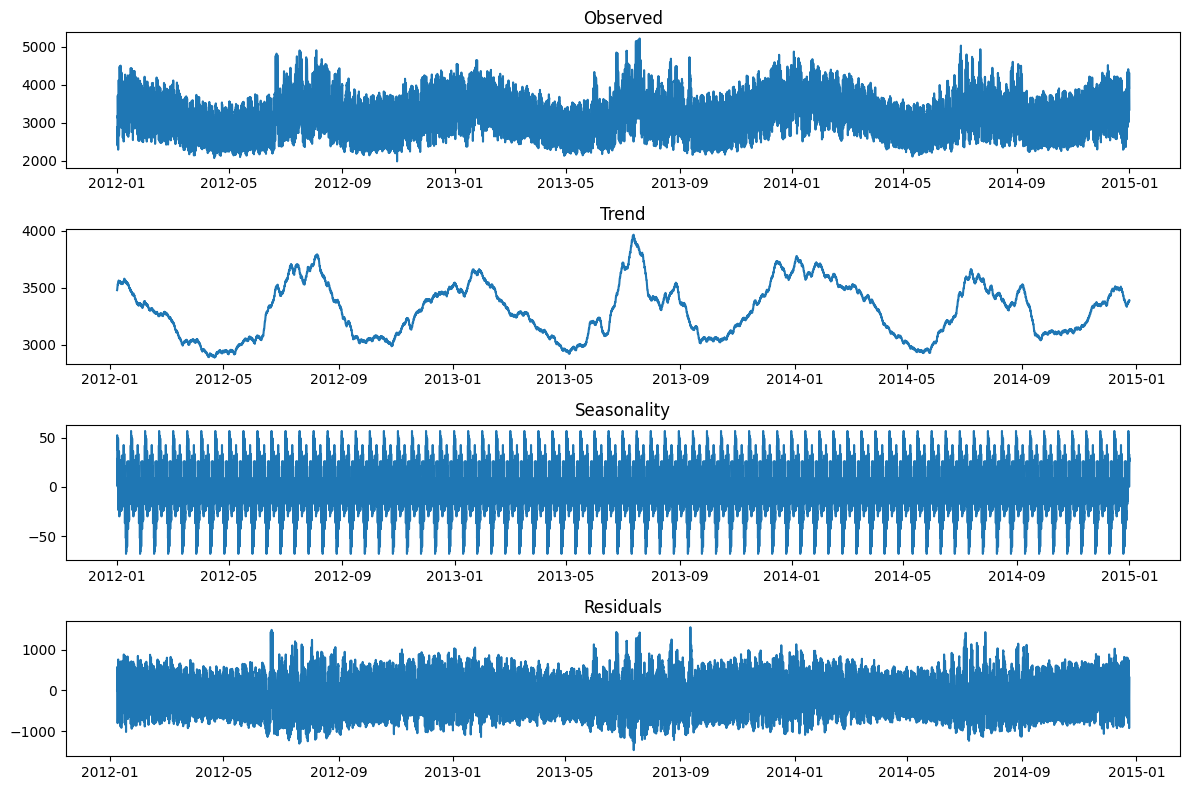

In [55]:
# Lets check some components of our Time Series
# Perform time series decomposition
result = sm.tsa.seasonal_decompose(df['Load Value'], model='additive', period=365)

# Plot the decomposed components
plt.figure(figsize=(12, 8))

# First the Observed plot
plt.subplot(4, 1, 1)
plt.plot(result.observed)
plt.title('Observed')

# The Trend plot
plt.subplot(4, 1, 2)
plt.plot(result.trend)
plt.title('Trend')

# The Seasonality plot
plt.subplot(4, 1, 3)
plt.plot(result.seasonal)
plt.title('Seasonality')

# The Residuals plot
plt.subplot(4, 1, 4)
plt.plot(result.resid)
plt.title('Residuals')

plt.tight_layout()
plt.show()

In [56]:
#test for stationarity
from statsmodels.tsa.stattools import adfuller

ADF_result = adfuller(df['Load Value'])

print(f'ADF Statistic: {ADF_result[0]}')
print(f'p-value: {ADF_result[1]}')

# Our time series is stationary

ADF Statistic: -10.40628174648381
p-value: 1.853221957624617e-18


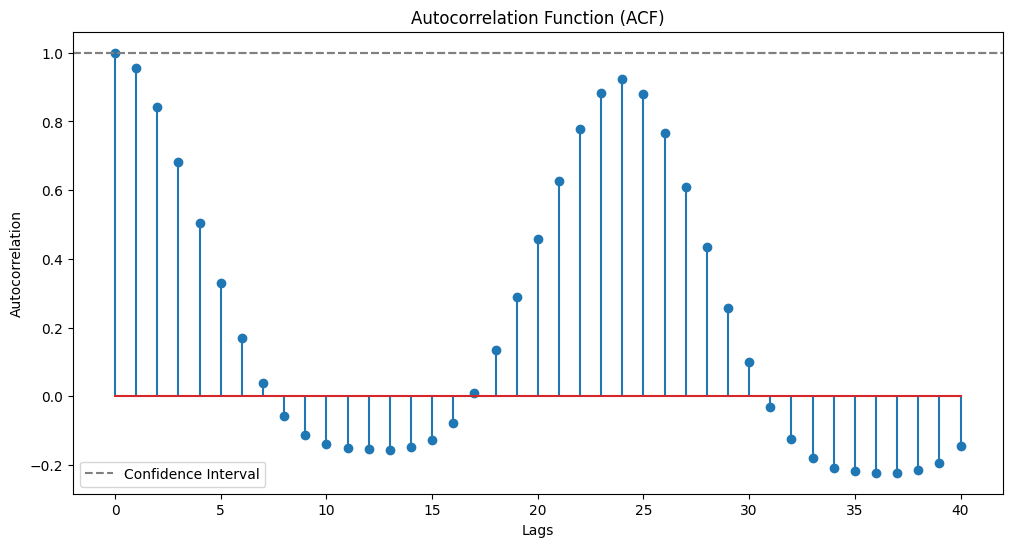

Autocorrelation remains significant beyond lag 2.


In [57]:
# Calculate autocorrelation and confidence intervals
acf_result, conf_int = sm.tsa.acf(df['Load Value'], nlags=40, alpha=0.05)

# Plot autocorrelation
plt.figure(figsize=(12, 6))
plt.stem(acf_result)#, use_line_collection=True)
plt.axhline(conf_int[0, 0], linestyle='--', color='gray', label='Confidence Interval')
plt.axhline(conf_int[0, 1], linestyle='--', color='gray')
plt.title('Autocorrelation Function (ACF)')
plt.xlabel('Lags')
plt.ylabel('Autocorrelation')
plt.legend()
plt.show()
# We have an autocorrelation

# Check if autocorrelation becomes non-significant after lag q
q = 2
significant_autocorrelation = (acf_result[:q] > conf_int[:q, 0]) & (acf_result[:q] < conf_int[:q, 1])
abrupt_non_significant = all(~significant_autocorrelation)

if abrupt_non_significant:
    print(f"Autocorrelation becomes non-significant after lag {q}.")
else:
    print(f"Autocorrelation remains significant beyond lag {q}.")

# The coeficients remains sifnificant beyond lag 2.   

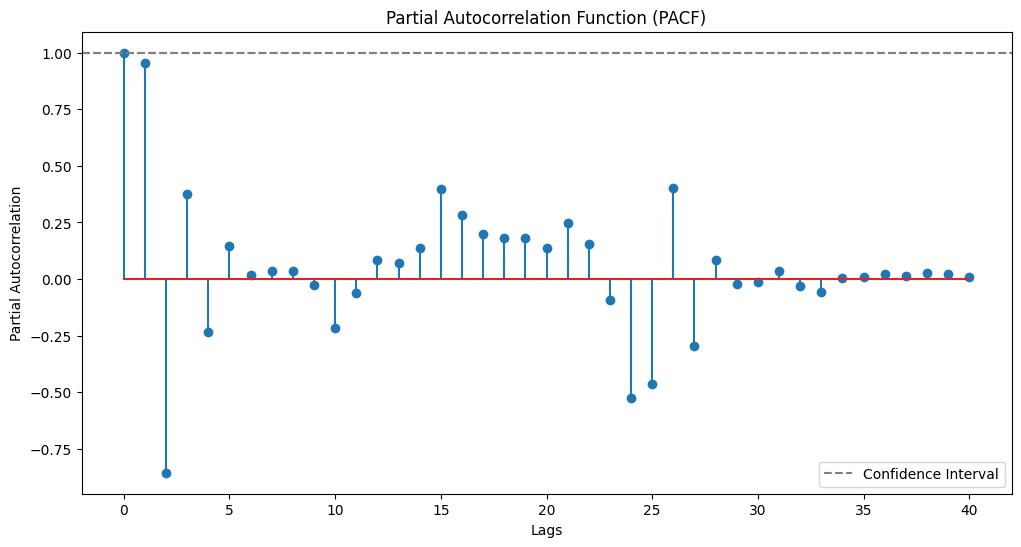

Partial autocorrelation remains significant beyond lag 2.


In [58]:
# Calculate partial autocorrelation and confidence intervals
pacf_result, conf_int = sm.tsa.pacf(df['Load Value'], nlags=40, alpha=0.05)

# Plot partial autocorrelation
plt.figure(figsize=(12, 6))
plt.stem(pacf_result)#, use_line_collection=True)
plt.axhline(conf_int[0, 0], linestyle='--', color='gray', label='Confidence Interval')
plt.axhline(conf_int[0, 1], linestyle='--', color='gray')
plt.title('Partial Autocorrelation Function (PACF)')
plt.xlabel('Lags')
plt.ylabel('Partial Autocorrelation')
plt.legend()
plt.show()
# We have a partial autocorrelation

# Check if partial autocorrelation becomes non-significant after lag p
p = 2 
significant_pacf = (pacf_result[:p] > conf_int[:p, 0]) & (pacf_result[:p] < conf_int[:p, 1])
abrupt_non_significant_pacf = all(~significant_pacf)

if abrupt_non_significant_pacf:
    print(f"Partial autocorrelation becomes non-significant after lag {p}.")
else:
    print(f"Partial autocorrelation remains significant beyond lag {p}.")

# The coeficients are significants after p = 2

In [59]:
# Interactive plot of time series
fig = go.Figure()
fig.add_trace(go.Scatter(x=train_set.index, y=train_set['Load Value'], mode='lines', name='Train'))
fig.add_trace(go.Scatter(x=val_set.index, y=val_set['Load Value'], mode='lines', name='Validation'))
fig.add_trace(go.Scatter(x=test_set.index, y=test_set['Load Value'], mode='lines', name='Test'))
fig.update_layout(
    title  = 'Hourly energy demand',
    xaxis_title="Time",
    yaxis_title="Load Value",
    legend_title="Partition:",
    width=850,
    height=400,
    margin=dict(l=20, r=20, t=35, b=20),
    legend=dict(
        orientation="h",
        yanchor="top",
        y=1,
        xanchor="left",
        x=0.001
    )
)
fig.show()

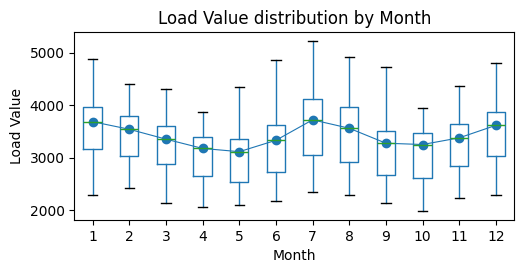

In [60]:
# Demand distribution by Month
fig, ax = plt.subplots(figsize=(5.5, 2.5))
df['Month'] = df.index.month
df.boxplot(column='Load Value', by='Month', ax=ax,)
df.groupby('Month')['Load Value'].median().plot(style='o-', linewidth=0.8, ax=ax)
ax.set_ylabel('Load Value')
ax.set_title('Load Value distribution by Month')
fig.suptitle('')
plt.show()

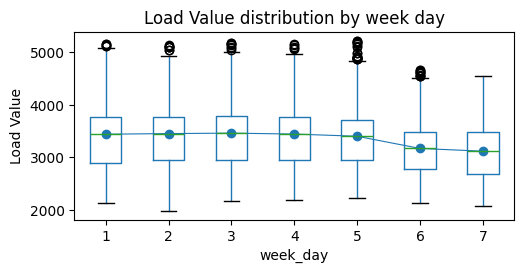

In [61]:
# Demand distribution by week day

fig, ax = plt.subplots(figsize=(5.5, 2.5))
df['week_day'] = df.index.day_of_week + 1
df.boxplot(column='Load Value', by='week_day', ax=ax)
df.groupby('week_day')['Load Value'].median().plot(style='o-', linewidth=0.8, ax=ax)
ax.set_ylabel('Load Value')
ax.set_title('Load Value distribution by week day')
fig.suptitle('')
plt.show()

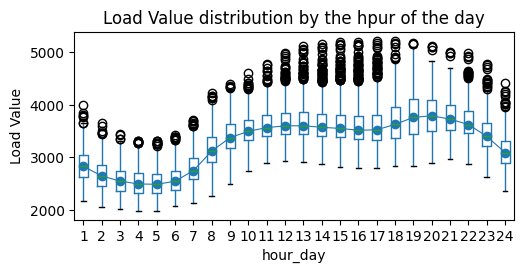

In [62]:
# Demand distribution by the hour of the day

fig, ax = plt.subplots(figsize=(5.5, 2.5))
df['hour_day'] = df.index.hour + 1
df.boxplot(column='Load Value', by='hour_day', ax=ax)
df.groupby('hour_day')['Load Value'].median().plot(style='o-', linewidth=0.8, ax=ax)
ax.set_ylabel('Load Value')
ax.set_title('Load Value distribution by the hpur of the day')
fig.suptitle('')
plt.show()

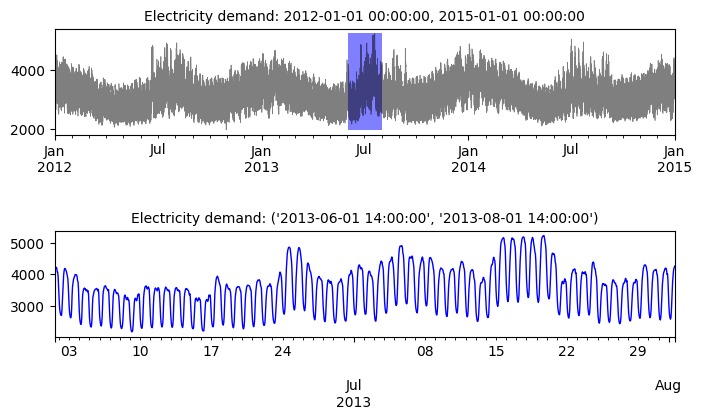

In [63]:
# Zooming time series chart
zoom = ('2013-06-01 14:00:00','2013-08-01 14:00:00')

fig = plt.figure(figsize=(8, 4))
grid = plt.GridSpec(nrows=8, ncols=1, hspace=0.6, wspace=0)

main_ax = fig.add_subplot(grid[:3, :])
df['Load Value'].plot(ax=main_ax, c='black', alpha=0.5, linewidth=0.5)
min_y = min(df['Load Value'])
max_y = max(df['Load Value'])
main_ax.fill_between(zoom, min_y, max_y, facecolor='blue', alpha=0.5, zorder=0)
main_ax.set_title(f'Electricity demand: {df.index.min()}, {df.index.max()}', fontsize=10)
main_ax.set_xlabel('')

zoom_ax = fig.add_subplot(grid[5:, :])
df.loc[zoom[0]: zoom[1]]['Load Value'].plot(ax=zoom_ax, color='blue', linewidth=1)
zoom_ax.set_title(f'Electricity demand: {zoom}', fontsize=10)
zoom_ax.set_xlabel('')

plt.subplots_adjust(hspace=1)
plt.show()
# We can see in these months the load value is high

In [64]:
def sliding_window(data, n, m):
    X, y = [], []
    for i in range(len(data) - n - m + 1):
        X.append(data.iloc[i:i+n].values)
        y.append(data.iloc[i+n:i+n+m].values)
    return np.array(X), np.array(y)

# Split data into training and testing sets using TimeSeriesSplit
tscv = TimeSeriesSplit(n_splits=5)

# Initialize lists to store X_train, y_train, X_test, y_test
X_train_list, y_train_list, X_test_list, y_test_list = [], [], [], []

n = 2
m = 1

# Apply sliding window transformation to each training and testing set
for train_index, test_index in tscv.split(df):
    train_data, test_data = df.iloc[train_index], df.iloc[test_index]

    # Apply sliding window transformation to training data
    X_train, y_train = sliding_window(train_data['Load Value'], n, m)
    X_train_list.append(X_train)
    y_train_list.append(y_train)

    # Apply sliding window transformation to testing data
    X_test, y_test = sliding_window(test_data['Load Value'], n, m)
    X_test_list.append(X_test)
    y_test_list.append(y_test)

# Concatenate the results
X_train = np.concatenate(X_train_list, axis=0)
y_train = np.concatenate(y_train_list, axis=0)
X_test = np.concatenate(X_test_list, axis=0)
y_test = np.concatenate(y_test_list, axis=0)

In [65]:
# Define a function to calculate MAPE
def calculate_mape(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

Linear Regression MAE: 61.550911572893284, RMSE: 85.45079985738272, MAPE: 1.820709415257965%


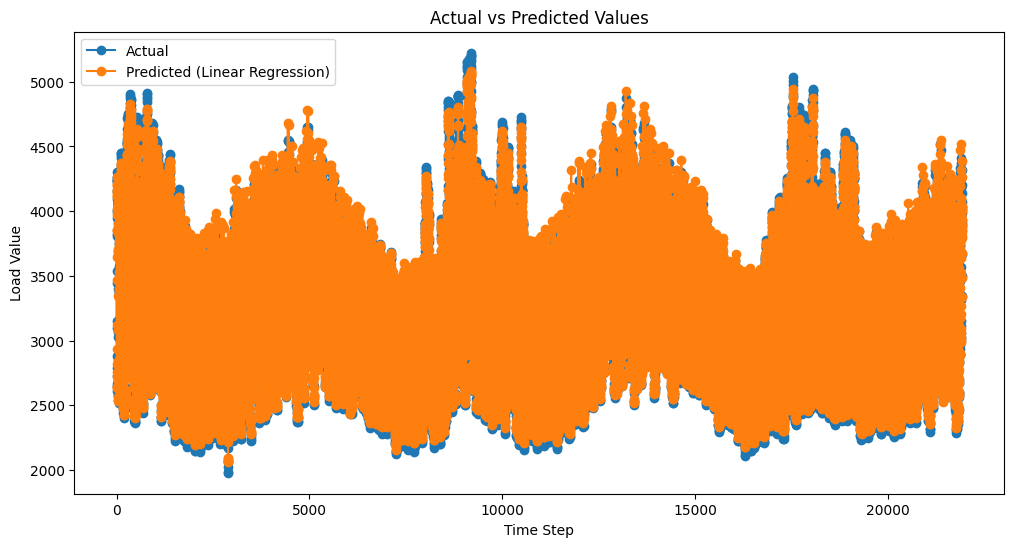

In [66]:
# Machine Learning Models
# Start by initialize the regression models:
# 1) Linear Regression
linear_model = LinearRegression()

# Start by do the train model
linear_model.fit(X_train, y_train)

# Make the prediction
linear_pred = linear_model.predict(X_test)

# Evaluate model
linear_mae = mean_absolute_error(y_test, linear_pred)

linear_rmse = mean_squared_error(y_test, linear_pred, squared=False)

linear_mape = calculate_mape(y_test, linear_pred)

print(f"Linear Regression MAE: {linear_mae}, RMSE: {linear_rmse}, MAPE: {linear_mape}%")

# Example with Linear Regression
y_pred_best_lr = linear_pred

plt.figure(figsize=(12, 6))

# Plot actual values
plt.plot(y_test, label='Actual', marker='o')

# Plot predicted values for Linear Regression
plt.plot(y_pred_best_lr, label='Predicted (Linear Regression)', marker='o')

plt.title('Actual vs Predicted Values')
plt.xlabel('Time Step')
plt.ylabel('Load Value')
plt.legend()
plt.show()

Decision Tree MAE: 14.327999826128535, RMSE: 45.8322863909991, MAPE: 20.324269550648246%


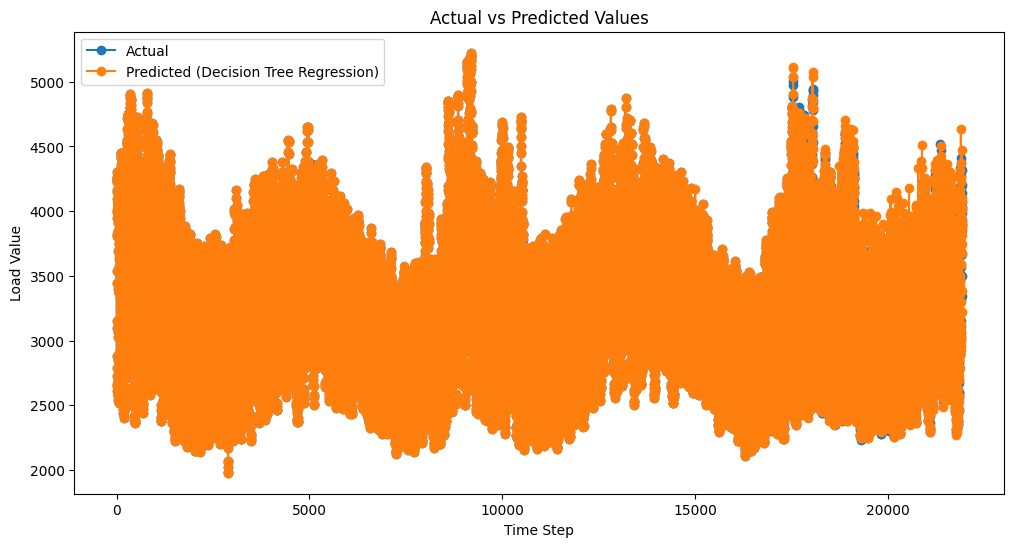

In [67]:
# 2) Decision Tree Regression
tree_model = DecisionTreeRegressor()

# Start by do the train model
tree_model.fit(X_train, y_train)

# Make the prediction
tree_pred = tree_model.predict(X_test)

# Evaluate model
tree_mae = mean_absolute_error(y_test, tree_pred)

tree_rmse = mean_squared_error(y_test, tree_pred, squared=False)

tree_mape = calculate_mape(y_test, tree_pred)

print(f"Decision Tree MAE: {tree_mae}, RMSE: {tree_rmse}, MAPE: {tree_mape}%")

# Example with Linear Regression
y_pred_best_lr = tree_pred

plt.figure(figsize=(12, 6))

# Plot actual values
plt.plot(y_test, label='Actual', marker='o')

# Plot predicted values for Decision Tree Regression
plt.plot(y_pred_best_lr, label='Predicted (Decision Tree Regression)', marker='o')

plt.title('Actual vs Predicted Values')
plt.xlabel('Time Step')
plt.ylabel('Load Value')
plt.legend()
plt.show()

c:\Users\diogo\anaconda3\Lib\site-packages\sklearn\base.py:1151: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().



Random Forest MAE: 18.703109915220615, RMSE: 40.18051787729388 , MAPE: 20.294847494185316%


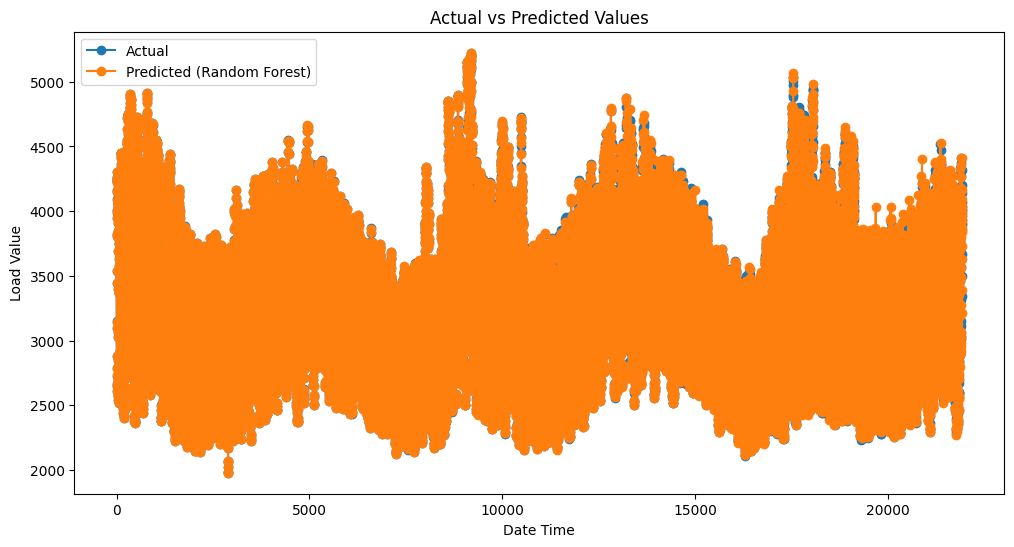

In [68]:
# 3) Random Forest Regression
rf_model = RandomForestRegressor()

# Start by do the train model
rf_model.fit(X_train, y_train)

# Make the prediction
rf_pred = rf_model.predict(X_test)

# Evaluate model
rf_mae = mean_absolute_error(y_test, rf_pred)

rf_rmse = mean_squared_error(y_test, rf_pred, squared=False)

rf_mape = calculate_mape(y_test, rf_pred)

print(f"Random Forest MAE: {rf_mae}, RMSE: {rf_rmse} , MAPE: {rf_mape}%")

# Example with Random Forest Regressor
y_pred_best_rf = rf_pred

plt.figure(figsize=(12, 6))

# Plot actual values
plt.plot(y_test, label='Actual', marker='o')

# Plot predicted values for Random Forest Regressor
plt.plot(y_pred_best_rf, label='Predicted (Random Forest)', marker='o')

plt.title('Actual vs Predicted Values')
plt.xlabel('Date Time')
plt.ylabel('Load Value')
plt.legend()
plt.show()

c:\Users\diogo\anaconda3\Lib\site-packages\sklearn\ensemble\_gb.py:424: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().



Gradient Boosting MAE: 58.491443664640855, RMSE: 83.01636899395065, MAPE: 20.048186133813516%


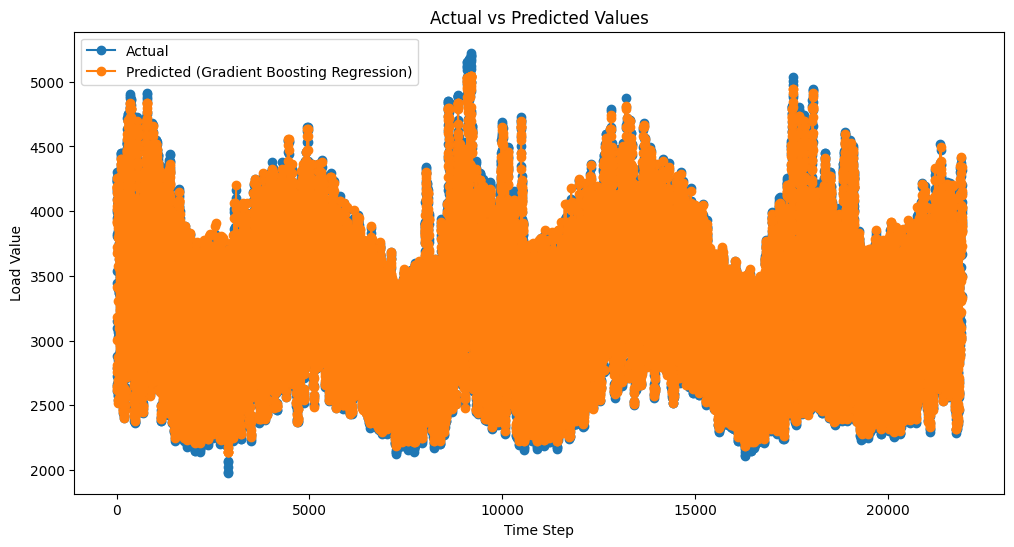

In [69]:
# 4) Gradient Boosting Regression
gb_model = GradientBoostingRegressor()

# Start by do the train model
gb_model.fit(X_train, y_train)

# Make the prediction
gb_pred = gb_model.predict(X_test)

# Evaluate model
gb_mae = mean_absolute_error(y_test, gb_pred)

gb_rmse = mean_squared_error(y_test, gb_pred, squared=False)

gb_mape = calculate_mape(y_test, gb_pred)

print(f"Gradient Boosting MAE: {gb_mae}, RMSE: {gb_rmse}, MAPE: {gb_mape}%")

# Example with Linear Regression
y_pred_best_lr = gb_pred

plt.figure(figsize=(12, 6))

# Plot actual values
plt.plot(y_test, label='Actual', marker='o')

# Plot predicted values for Gradient Boosting Regression
plt.plot(y_pred_best_lr, label='Predicted (Gradient Boosting Regression)', marker='o')

plt.title('Actual vs Predicted Values')
plt.xlabel('Time Step')
plt.ylabel('Load Value')
plt.legend()
plt.show()

Linear Regression - MAE: 61.550911572893284, MSE: 7301.839196266479, MAPE: 1.82%
Random Forest - MAE: 18.703109915220615, MSE: 1614.474016887533, MAPE: 20.29%
Decision Tree - MAE: 61.550911572893284, MSE: 7301.839196266479, MAPE: 1.82%
Gradient Boosting - MAE: 14.327999826128535, MSE: 2100.5984758265618, MAPE: 20.32%


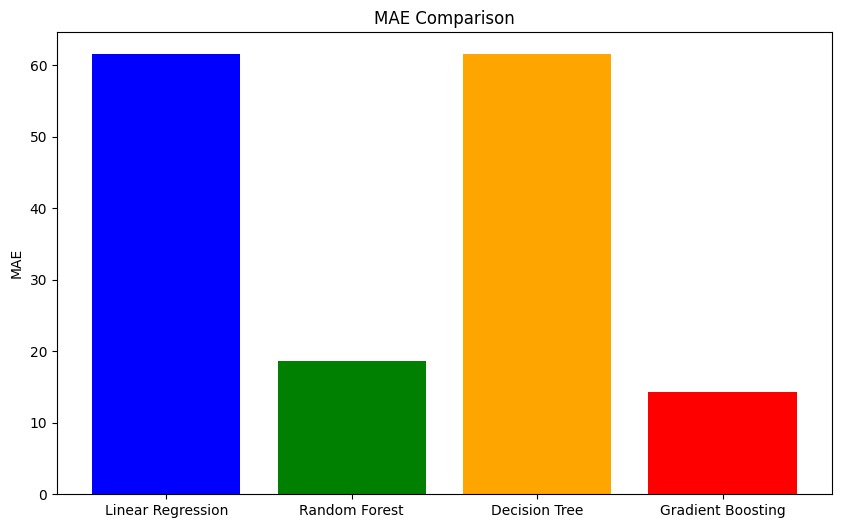

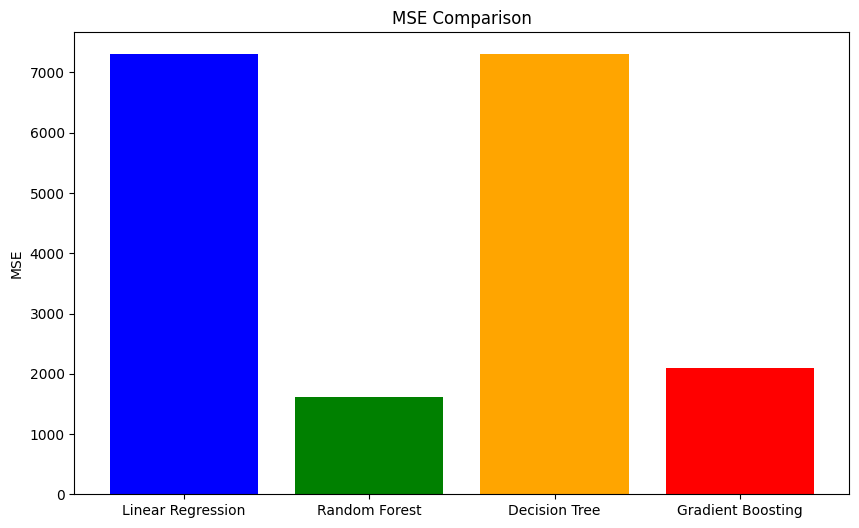

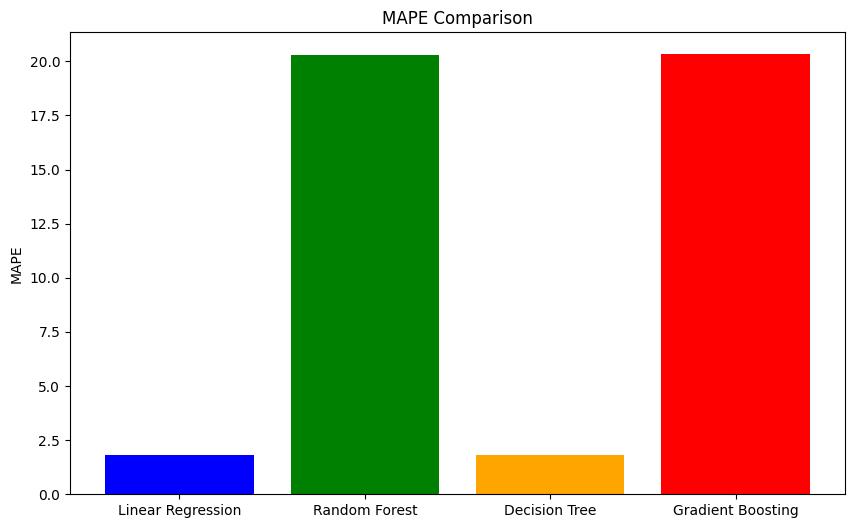

In [70]:
# Evaluate models using appropriate metrics
def evaluate_model(y_true, y_pred, model_name):
    mae = mean_absolute_error(y_true, y_pred)
    mse = mean_squared_error(y_true, y_pred)
    mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100  
    print(f"{model_name} - MAE: {mae}, MSE: {mse}, MAPE: {mape:.2f}%")
    
    # Return metrics as a dictionary
    return {"MAE": mae, "MSE": mse, "MAPE": mape}

# Model predictions and evaluation metrics
models = ["Linear Regression", "Random Forest", "Decision Tree", "Gradient Boosting"]
predictions = [linear_pred, rf_pred, linear_pred, tree_pred]

# Dictionary to store evaluation metrics
all_metrics = {}

# Evaluate and store metrics for each model
for model_name, y_pred in zip(models, predictions):
    metrics = evaluate_model(y_test, y_pred, model_name)
    all_metrics[model_name] = metrics

# Create a bar plot for each metric
metric_names = list(all_metrics["Linear Regression"].keys())

for metric_name in metric_names:
    values = [all_metrics[model][metric_name] for model in all_metrics]
    
    plt.figure(figsize=(10, 6))
    plt.bar(all_metrics.keys(), values, color=['blue', 'green', 'orange', 'red'])
    plt.title(f"{metric_name} Comparison")
    plt.ylabel(metric_name)
    plt.show()

In [71]:
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller

# Function to identify d and D
def identify_d_D(ts):
    # Check for missing values
    if ts.isnull().any():
        raise ValueError("Time series contains missing values. Please handle or remove them.")

    # Non-seasonal differencing
    d = 0
    while adfuller(ts, autolag='AIC')[1] > 0.05:  # Check p-value for stationarity
        ts = ts.diff().dropna()
        d += 1

    # Seasonal differencing (assuming a certain seasonality, e.g., 24 hours for daily data)
    seasonal_period = 24
    D = 0
    while adfuller(ts, autolag='AIC')[1] > 0.05:  # Check p-value for stationarity
        ts = ts.diff(seasonal_period).dropna()
        D += 1

    return d, D

# Example usage with a DataFrame with a datetime index
# Assuming 'value' is the column containing the time series
df = df.asfreq('H')
subset_start_date = '2012-01-01 00:00:00'
subset_end_date = '2012-01-11 00:00:00'
subset_data = df.loc[subset_start_date:subset_end_date]

df = pd.DataFrame(subset_data['Load Value'])

# Extract the time series from the DataFrame
ts = df['Load Value']

# Example usage
d, D = identify_d_D(ts)


# Example usage
d, D = identify_d_D(ts)
print(f"Non-seasonal differencing order (d): {d}")
print(f"Seasonal differencing order (D): {D}")

Non-seasonal differencing order (d): 1
Seasonal differencing order (D): 0


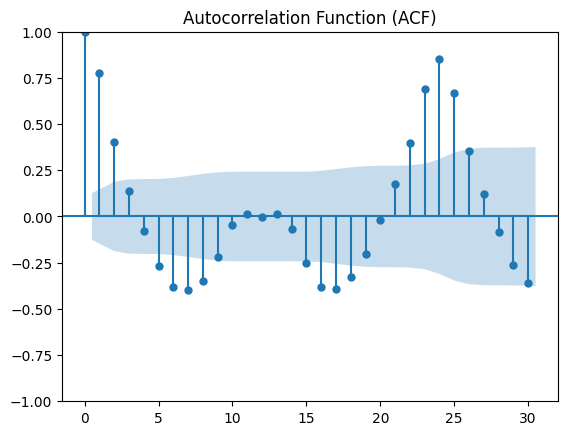

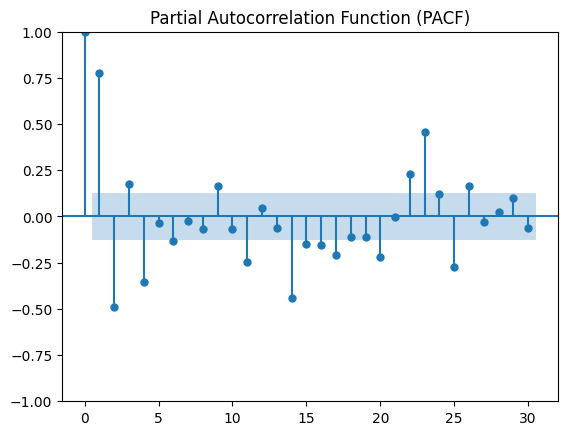

Autoregressive order (p): 5
Seasonal autoregressive order (P): 2


In [72]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf


# Function to identify p and P
def identify_p_P(ts, seasonal_period):
    # Plot ACF and PACF for the differenced and seasonally differenced series
    plot_acf(ts, lags=30)
    plt.title('Autocorrelation Function (ACF)')
    plt.show()

    plot_pacf(ts, lags=30)
    plt.title('Partial Autocorrelation Function (PACF)')
    plt.show()

    # Identify p and P based on PACF and seasonal PACF
    p = int(input("Enter the value of p based on PACF: "))
    P = int(input("Enter the value of P based on seasonal PACF: "))

    return p, P

# Example usage
seasonal_period = 24  # Assuming daily seasonality for hourly data
differenced_ts = ts.diff().dropna()  # Assuming ts is the differenced series

p, P = identify_p_P(differenced_ts, seasonal_period)
print(f"Autoregressive order (p): {p}")
print(f"Seasonal autoregressive order (P): {P}")

In [73]:
import statsmodels.api as sm

m = seasonal_period

#
# Manually define SARIMA parameters
p, q = 5, 5  # Non-seasonal orders
P, Q= 2, 2  # Seasonal orders

# Create SARIMA model
sarima_model = sm.tsa.SARIMAX(ts, order=(p, d, q), seasonal_order=(P, D, Q, m))

# Fit the model to the training data
sarima_result = sarima_model.fit()

# Get AIC from the model summary
aic = sarima_result.aic

print(f"Akaike Information Criterion (AIC): {aic}")


c:\Users\diogo\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning:

Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.

c:\Users\diogo\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning:

Non-invertible starting MA parameters found. Using zeros as starting parameters.

c:\Users\diogo\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:1009: UserWarning:

Non-invertible starting seasonal moving average Using zeros as starting parameters.

c:\Users\diogo\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



Akaike Information Criterion (AIC): 2531.6182873247635


c:\Users\diogo\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning:

Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.

c:\Users\diogo\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning:

Non-invertible starting MA parameters found. Using zeros as starting parameters.

c:\Users\diogo\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:1009: UserWarning:

Non-invertible starting seasonal moving average Using zeros as starting parameters.

c:\Users\diogo\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



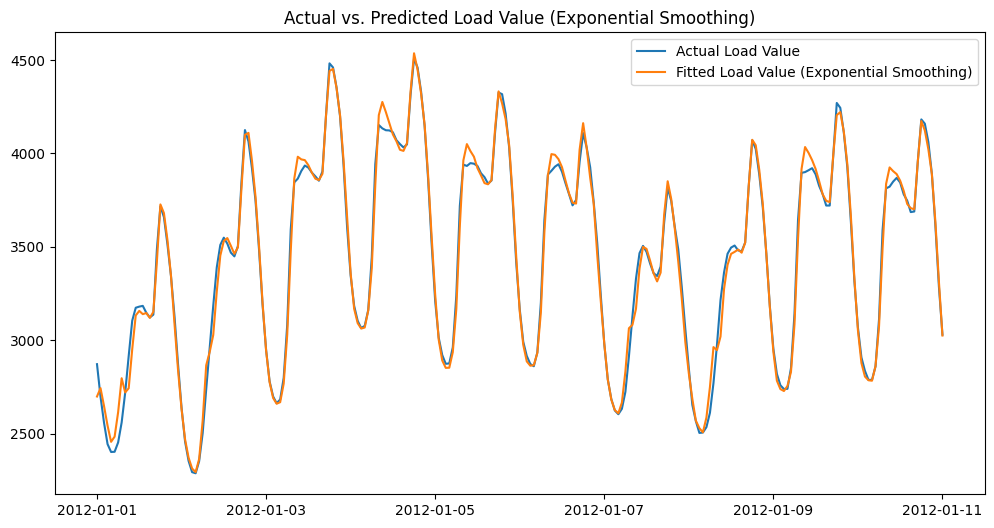

Exponential Smoothing Model Performance:
MAE: 36.89
RMSE: 56.01


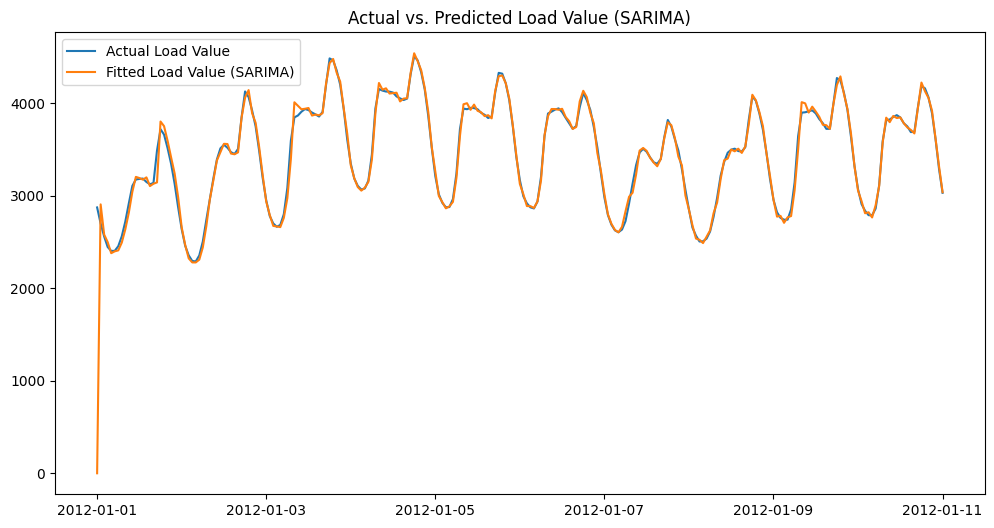


SARIMA Model Performance:
MAE: 45.10
RMSE: 191.66


In [75]:
# Statistical Model

from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.tsa.statespace.sarimax import SARIMAX

#copy df
df_copy = df.copy()

# Set the frequency explicitly to 'H' (hourly)
df_copy = df_copy.asfreq('H')

subset_start_date = '2012-01-01 00:00:00'
subset_end_date = '2013-01-01 00:00:00'
subset_data = df_copy.loc[subset_start_date:subset_end_date]

# Exponential Smoothing
model_exp = ExponentialSmoothing(subset_data['Load Value'], trend='add', seasonal='add', seasonal_periods=24)
result_exp = model_exp.fit()
fitted_values_exp = result_exp.fittedvalues

# SARIMA
model_sarima = SARIMAX(subset_data['Load Value'], order=(p, d, q), seasonal_order=(P, D, Q, m))
result_sarima = model_sarima.fit()
fitted_values_sarima = result_sarima.fittedvalues

# Validate the model
mae_exp = mean_absolute_error(subset_data['Load Value'], fitted_values_exp)
rmse_exp = mean_squared_error(subset_data['Load Value'], fitted_values_exp, squared=False)

mae_sarima = mean_absolute_error(subset_data['Load Value'], fitted_values_sarima)
rmse_sarima = mean_squared_error(subset_data['Load Value'], fitted_values_sarima, squared=False)

# Visualize Actual vs. Predicted Values
plt.figure(figsize=(12, 6))
plt.plot(subset_data['Load Value'], label='Actual Load Value')
plt.plot(fitted_values_exp, label='Fitted Load Value (Exponential Smoothing)')
plt.title('Actual vs. Predicted Load Value (Exponential Smoothing)')
plt.legend()
plt.show()

print("Exponential Smoothing Model Performance:")
print("MAE: {:.2f}".format(mae_exp))
print("RMSE: {:.2f}".format(rmse_exp))


plt.figure(figsize=(12, 6))
plt.plot(subset_data['Load Value'], label='Actual Load Value')
plt.plot(fitted_values_sarima, label='Fitted Load Value (SARIMA)')
plt.title('Actual vs. Predicted Load Value (SARIMA)')
plt.legend()
plt.show()

print("\nSARIMA Model Performance:")
print("MAE: {:.2f}".format(mae_sarima))
print("RMSE: {:.2f}".format(rmse_sarima))

In [77]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, GRU, Dense


# Load your time series data (replace 'your_file.csv' with your actual file)
# ts_data = pd.read_csv('your_file.csv')
# Extract the time series values
ts_values = df['Load Value'].values.reshape(-1, 1)

# Scale the data
scaler = MinMaxScaler()
ts_scaled = scaler.fit_transform(ts_values)

# Define a function to create sequences for LSTM/GRU
def create_sequences(data, seq_length):
    sequences = []
    for i in range(len(data)-seq_length):
        seq = data[i:i+seq_length]
        sequences.append(seq)
    return np.array(sequences)

# Define the sequence length (adjust as needed)
seq_length = 10

# Create sequences for LSTM/GRU
sequences = create_sequences(ts_scaled, seq_length)

# Split the data into training and testing sets
train_size = int(len(sequences) * 0.8)
train_data, test_data = sequences[:train_size], sequences[train_size:]

# Split into features and target
X_train, y_train = train_data[:, :-1], train_data[:, -1]
X_test, y_test = test_data[:, :-1], test_data[:, -1]

# Reshape the data for LSTM/GRU
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)


In [78]:
#LSTM Model 

model_lstm = Sequential()
model_lstm.add(LSTM(units=50, input_shape=(X_train.shape[1], 1)))
model_lstm.add(Dense(units=1))
model_lstm.compile(optimizer='adam', loss='mse')

# Train the model
model_lstm.fit(X_train, y_train, epochs=50, batch_size=32, validation_split=0.1)

# Make predictions
y_pred_lstm = model_lstm.predict(X_test)

# Inverse transform the predictions
y_pred_lstm_inv = scaler.inverse_transform(y_pred_lstm.reshape(-1, 1))

# Evaluate the model
mse_lstm = mean_squared_error(ts_values[seq_length+train_size:], y_pred_lstm_inv)
print(f'Mean Squared Error (LSTM): {mse_lstm}')


c:\Users\diogo\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:205: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



Epoch 1/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 3s 96ms/step - loss: 0.2311 - val_loss: 0.1079
Epoch 2/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0875 - val_loss: 0.0364
Epoch 3/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0512 - val_loss: 0.0303
Epoch 4/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0692 - val_loss: 0.0271
Epoch 5/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0478 - val_loss: 0.0288
Epoch 6/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0451 - val_loss: 0.0315
Epoch 7/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0430 - val_loss: 0.0306
Epoch 8/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0456 - val_loss: 0.0265
Epoch 9/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0440 - val_loss: 0.0242
Epoch 10/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0435 - val_loss: 0.0234
Epoch 11/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0393 - val_loss: 0.0235
Epoch 12/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0380 - val_loss: 0.0241
E

In [79]:
# GRU Model

model_gru = Sequential()
model_gru.add(GRU(units=50, input_shape=(X_train.shape[1], 1)))
model_gru.add(Dense(units=1))
model_gru.compile(optimizer='adam', loss='mse')

# Train the model
model_gru.fit(X_train, y_train, epochs=50, batch_size=32, validation_split=0.1)

# Make predictions
y_pred_gru = model_gru.predict(X_test)

# Inverse transform the predictions
y_pred_gru_inv = scaler.inverse_transform(y_pred_gru.reshape(-1, 1))

# Evaluate the model
mse_gru = mean_squared_error(ts_values[seq_length+train_size:], y_pred_gru_inv)
print(f'Mean Squared Error (GRU): {mse_gru}')


Epoch 1/50


c:\Users\diogo\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:205: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



6/6 ━━━━━━━━━━━━━━━━━━━━ 4s 157ms/step - loss: 0.3164 - val_loss: 0.1627
Epoch 2/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.1624 - val_loss: 0.0710
Epoch 3/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0723 - val_loss: 0.0237
Epoch 4/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0424 - val_loss: 0.0210
Epoch 5/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0444 - val_loss: 0.0209
Epoch 6/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0372 - val_loss: 0.0171
Epoch 7/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0324 - val_loss: 0.0167
Epoch 8/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0293 - val_loss: 0.0169
Epoch 9/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0297 - val_loss: 0.0160
Epoch 10/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0291 - val_loss: 0.0151
Epoch 11/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0267 - val_loss: 0.0146
Epoch 12/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0260 - val_loss: 0.0141
Epoch 13/50